Импортируем все библиотеки

In [1]:
# !pip install tensorflow

In [2]:
import pandas as pd
from IPython.display import display
pd.options.display.max_columns = None
pd.options.display.max_rows = None
import missingno as msno
import numpy as np
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, make_scorer, precision_recall_curve
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.multioutput import MultiOutputClassifier
from pathlib import Path
from livelossplot.tf_keras import PlotLossesCallback
import tensorflow as tf
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import accuracy_score
from keras.models import load_model

Загружаем датасет из csv-файла

In [3]:
df = pd.read_csv('train.csv')
df.head()

,ID,Пол,Семья,Этнос,Национальность,Религия,Образование,Профессия,Вы работаете?,Выход на пенсию,Прекращение работы по болезни,Сахарный диабет,Гепатит,Онкология,Хроническое заболевание легких,Бронжиальная астма,Туберкулез легких,ВИЧ/СПИД,Регулярный прим лекарственных средств,Травмы за год,Переломы,Статус Курения,Возраст курения,Сигарет в день,Пассивное курение,Частота пасс кур,Алкоголь,Возраст алког,Время засыпания,Время пробуждения,Сон после обеда,"Спорт, клубы","Религия, клубы",ID_y,Артериальная гипертензия,ОНМК,"Стенокардия, ИБС, инфаркт миокарда",Сердечная недостаточность,Прочие заболевания сердца
0,54-102-358-02,М,в браке в настоящее время,европейская,Русские,Христианство,3 - средняя школа / закон.среднее / выше среднего,низкоквалифицированные работники,1,0,0,0,0,0,0,0,0,0,0,0,0,Курит,15.0,20.0,0,NaN,употребляю в настоящее время,18.0,22:00:00,06:00:00,0,0,0,54-102-358-02,0,0,0,0,0
1,54-103-101-01,Ж,в разводе,европейская,Русские,Христианство,5 - ВУЗ,дипломированные специалисты,0,0,0,1,0,0,0,0,0,0,1,0,1,Никогда не курил(а),NaN,NaN,0,NaN,никогда не употреблял,NaN,00:00:00,04:00:00,1,0,0,54-103-101-01,1,1,0,0,0
2,54-501-026-03,Ж,в браке в настоящее время,европейская,Русские,Христианство,5 - ВУЗ,дипломированные специалисты,0,0,0,0,0,0,0,0,0,0,1,0,0,Никогда не курил(а),NaN,NaN,1,1-2 раза в неделю,употребляю в настоящее время,17.0,23:00:00,07:00:00,0,0,0,54-501-026-03,0,0,0,0,0
3,54-501-094-02,М,в браке в настоящее время,европейская,Русские,Атеист / агностик,3 - средняя школа / закон.среднее / выше среднего,низкоквалифицированные работники,1,0,0,0,0,1,0,0,0,0,1,0,0,Бросил(а),12.0,10.0,1,3-6 раз в неделю,употребляю в настоящее время,13.0,23:00:00,07:00:00,0,0,0,54-501-094-02,1,0,0,0,0
4,54-503-022-01,Ж,в браке в настоящее время,европейская,Русские,Христианство,3 - средняя школа / закон.среднее / выше среднего,операторы и монтажники установок и машинного о...,0,0,1,1,1,0,0,0,0,0,1,0,1,Никогда не курил(а),NaN,NaN,1,не менее 1 раза в день,употребляю в настоящее время,16.0,23:00:00,06:00:00,0,0,0,54-503-022-01,1,0,1,1,0


# Почистим данные

Посмотрим, сколько у нас объектов и сколько фичей

In [4]:
print(f'В датасете {df.shape[0]} пациентов и {df.shape[1]} фичей')

В датасете 955 пациентов и 39 фичей


Проверим на пропущенные данные

<AxesSubplot:>

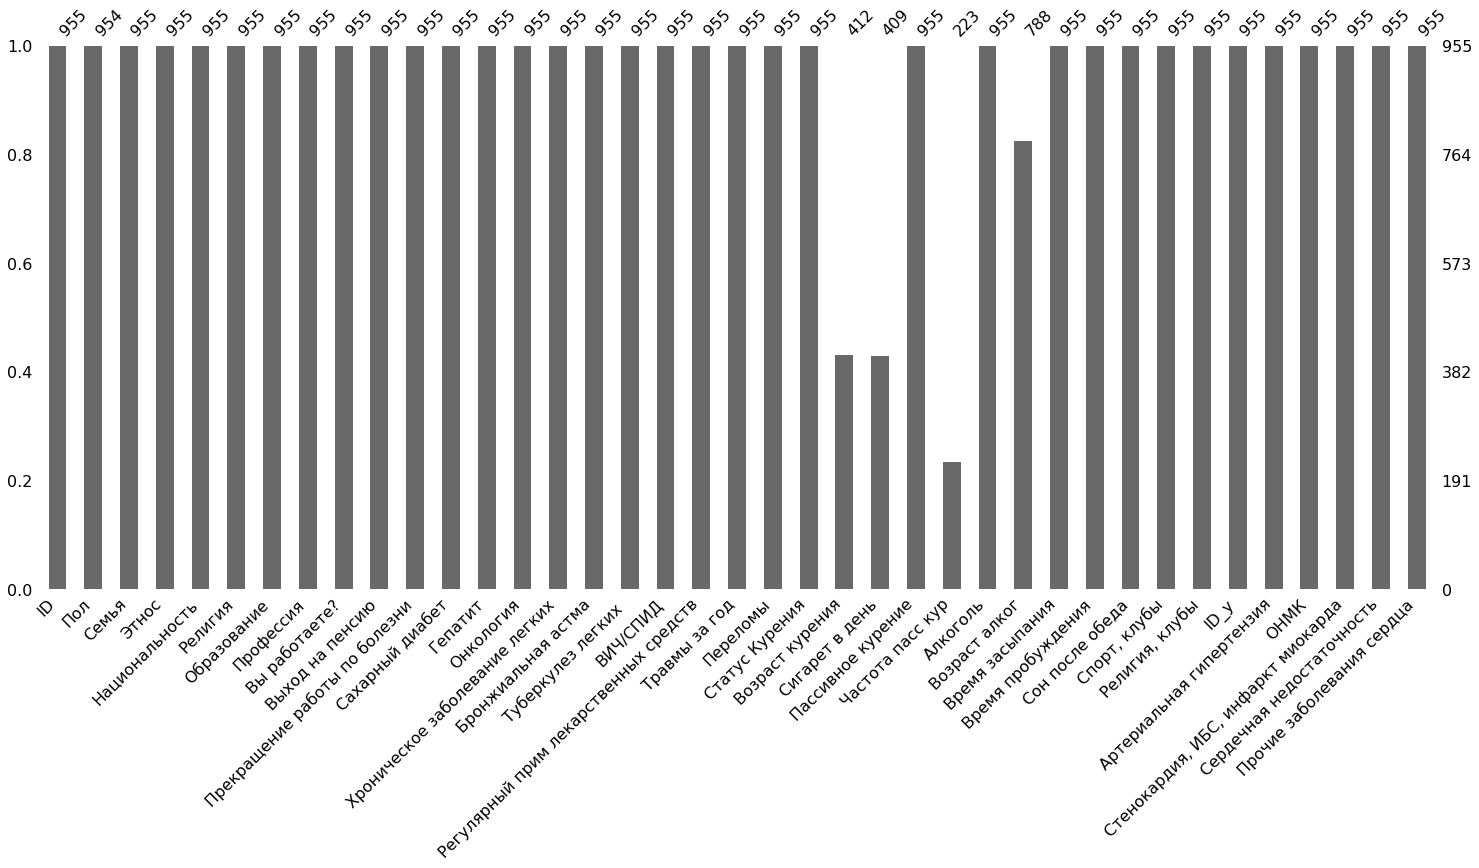

In [5]:
msno.bar(df)

Как мы видим, статус курения указан для всех пациентов. При этом возраст курения указан только для 412 человек. Проверим, соответствует ли это количеству курящих.

In [6]:
df['Статус Курения'].value_counts()

Никогда не курил(а)    543
Курит                  221
Бросил(а)              191
Name: Статус Курения, dtype: int64

221 + 191 = 412. Все правильно. При этом количество сигарет в день указано только для 409 человек. Похоже трое не стали указывать этот параметр. Проверим это

In [7]:
df[(df['Статус Курения'] != 'Никогда не курил(а)') & (df['Сигарет в день'].isna())]\
[['ID', 'Статус Курения', 'Возраст курения', 'Сигарет в день']]

,ID,Статус Курения,Возраст курения,Сигарет в день
123,54-102-244-02,Бросил(а),18.0,NaN
354,54-601-015-02,Курит,25.0,NaN
886,54-602-038-01,Курит,52.0,NaN


Создадим пока резервный датафрейм, куда помести этих троих, убрав их из основного датасета. В дальнейшем, если мы посчитаем, что влияние количества выкуренных сигарет в день на целевые признаки незначительно по сравнению с другими фичами, мы, возможно, вернем этих пациентов в датасет.

In [8]:
reserve_df = df[df['ID'].isin(['54-102-244-02', '54-601-015-02', '54-602-038-01'])]
df = df[(df['ID'].isin(['54-102-244-02', '54-601-015-02', '54-602-038-01'])) == False]
df.shape

(952, 39)

Аналогично проверим соответствие количества пассивно курящих и количества указавших частоту пассивного курения.

In [9]:
df['Пассивное курение'].value_counts()

0    728
1    224
Name: Пассивное курение, dtype: int64

Пассивно курят 224 человека, а частоту указали 223. Посмотрим, кто не указал.

In [10]:
df[(df['Пассивное курение'] == 1) & (df['Частота пасс кур'].isna())]\
[['ID', 'Пассивное курение', 'Частота пасс кур']]

,ID,Пассивное курение,Частота пасс кур
175,54-102-340-01,1,NaN
247,54-701-024-02,1,NaN


Оказывается, частоту курения не указали двое из 224 пассивно курящих. Значит еще один человек дал неверные сведения - что он не курит пассивно, но при этом указал частоту. Проверим.

In [11]:
df[(df['Пассивное курение'] == 0) & (df['Частота пасс кур'].isna() == False)]\
[['ID', 'Пассивное курение', 'Частота пасс кур']]

,ID,Пассивное курение,Частота пасс кур
392,54-001-079-01,0,3-6 раз в неделю


Этого пациента смело удаляем из данных, а первых двух - в резерв.

In [12]:
reserve_df = pd.merge(reserve_df, df[df['ID'].isin(['54-102-340-01', '54-701-024-02'])], how = 'outer')
df = df[(df['ID'].isin(['54-102-340-01', '54-701-024-02', '54-001-079-01'])) == False]
df.shape

C:\Users\Michael\anaconda3\lib\site-packages\pandas\core\reshape\merge.py:916: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  key_col = Index(lvals).where(~mask_left, rvals)


(949, 39)

Осталось разобраться с алкоголиками

In [13]:
df['Алкоголь'].value_counts()

употребляю в настоящее время    630
никогда не употреблял           165
ранее употреблял                154
Name: Алкоголь, dtype: int64

634 + 156 = 790 человек употребляют или употребляли алкоголь, а длительность периода приема указали 788. Проверим это соответствие.

In [14]:
df[(df['Алкоголь'] != 'никогда не употреблял') & (df['Возраст алког'].isna())]\
[['ID', 'Алкоголь', 'Возраст алког']]

,ID,Алкоголь,Возраст алког
451,54-102-238-02,употребляю в настоящее время,NaN
545,54-701-032-01,употребляю в настоящее время,NaN


Действительно, двое из пьющих не указали период приема алкоголя. Убираем их из основного датафрейма в резервный.

In [15]:
reserve_df = pd.merge(reserve_df, df[df['ID'].isin(['54-102-238-02', '54-701-032-01'])], how = 'outer')
df = df[(df['ID'].isin(['54-102-238-02', '54-701-032-01'])) == False]
df.shape

C:\Users\Michael\anaconda3\lib\site-packages\pandas\core\reshape\merge.py:916: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  key_col = Index(lvals).where(~mask_left, rvals)


(947, 39)

Также в столбце "Пол" отсутствует одно значение.

In [16]:
df[df['Пол'].isin(['М', 'Ж']) == False]

,ID,Пол,Семья,Этнос,Национальность,Религия,Образование,Профессия,Вы работаете?,Выход на пенсию,Прекращение работы по болезни,Сахарный диабет,Гепатит,Онкология,Хроническое заболевание легких,Бронжиальная астма,Туберкулез легких,ВИЧ/СПИД,Регулярный прим лекарственных средств,Травмы за год,Переломы,Статус Курения,Возраст курения,Сигарет в день,Пассивное курение,Частота пасс кур,Алкоголь,Возраст алког,Время засыпания,Время пробуждения,Сон после обеда,"Спорт, клубы","Религия, клубы",ID_y,Артериальная гипертензия,ОНМК,"Стенокардия, ИБС, инфаркт миокарда",Сердечная недостаточность,Прочие заболевания сердца
304,54-701-009-01,NaN,гражданский брак / проживание с партнером,европейская,Русские,Нет,3 - средняя школа / закон.среднее / выше среднего,"работники, занятые в сфере обслуживания, торг...",1,0,0,0,0,0,0,0,0,0,0,0,0,Курит,18.0,3.0,0,NaN,употребляю в настоящее время,20.0,01:00:00,06:30:00,0,0,0,54-701-009-01,0,0,0,0,0


Перенесем и этого пациента в резерв

In [17]:
reserve_df = pd.merge(reserve_df, df[df['ID'] == '54-701-009-01'], how = 'outer')
df = df[df['ID'] != '54-701-009-01']
df.shape

C:\Users\Michael\anaconda3\lib\site-packages\pandas\core\reshape\merge.py:916: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  key_col = Index(lvals).where(~mask_left, rvals)


(946, 39)

Проверим, одинаковы ли значения в столбцах 'ID' и 'ID_y'

In [18]:
df[df[['ID','ID_y']].nunique(axis=1) == 0].shape

(0, 39)

Эти столбцы абсолютно идентичны. Удалим 'ID_y', а 'ID' сделаем индексом

In [19]:
df = df.drop(['ID_y'], axis = 1)
df = df.set_index('ID')

Проверим типы столбцов

In [20]:
df.dtypes

Пол                                       object
Семья                                     object
Этнос                                     object
Национальность                            object
Религия                                   object
Образование                               object
Профессия                                 object
Вы работаете?                              int64
Выход на пенсию                            int64
Прекращение работы по болезни              int64
Сахарный диабет                            int64
Гепатит                                    int64
Онкология                                  int64
Хроническое заболевание легких             int64
Бронжиальная астма                         int64
Туберкулез легких                          int64
ВИЧ/СПИД                                   int64
Регулярный прим лекарственных средств      int64
Травмы за год                              int64
Переломы                                   int64
Статус Курения      

Приведем столбцы "Время засыпания" и "Время пробуждения" к типу даты и времени.

In [21]:
df[['Время засыпания', 'Время пробуждения']] = df[['Время засыпания', 'Время пробуждения']].astype('datetime64')
df[['Время засыпания', 'Время пробуждения']].dtypes

Время засыпания      datetime64[ns]
Время пробуждения    datetime64[ns]
dtype: object

Введём новый столбец - "Время сна". Он тоже может влиять на целевые показатели

In [22]:
df['Время сна'] = df['Время пробуждения'] - df['Время засыпания']

In [23]:
def sleep_time(x):
    x = int(x.total_seconds()) // 3600
    if x < 0:
        x += 24
    return x
df['Время сна'] = df['Время сна'].apply(lambda x: sleep_time(x))

Проверим достоверность полученных данных

In [24]:
df['Время сна'].value_counts()

7     284
8     249
9     138
6     132
10     62
5      39
11     15
4      14
12      6
3       3
13      2
19      1
0       1
Name: Время сна, dtype: int64

Так как время засыпания и пробуждения пациенты указывали в среднем для определенного периода, а не для одного какого-то дня, то показатель времени сна в 19 часов каждый день явно неправдоподобен. Такой пациент один. Давайте лучше удалим его, чтобы он не вносил погрешность в наши исследования.

In [25]:
df[df['Время сна'] == 19][['Время засыпания', 'Время пробуждения']]

,Время засыпания,Время пробуждения
ID,,
54-002-054-02,2022-06-19 12:00:00,2022-06-19 07:00:00


Действительно маловероятно засыпать в 12 и просыпаться в 7 каждый день. Удаляем.

In [26]:
df = df[df['Время сна'] != 19]

Три столбца имеют тип float, хотя по сути это целые числа. Это связано с наличием NaN-значений. В данном случае их все можно заменить нулями, и привести столбцы к типу int.

In [27]:
df = df.fillna(0)
df[['Возраст курения', 'Сигарет в день', 'Возраст алког']] =\
df[['Возраст курения', 'Сигарет в день', 'Возраст алког']].astype('int64')

Посмотрим некоторые статистические данные по числовым и категориальным признакам.

In [28]:
df.describe(include=[np.number])

,Вы работаете?,Выход на пенсию,Прекращение работы по болезни,Сахарный диабет,Гепатит,Онкология,Хроническое заболевание легких,Бронжиальная астма,Туберкулез легких,ВИЧ/СПИД,Регулярный прим лекарственных средств,Травмы за год,Переломы,Возраст курения,Сигарет в день,Пассивное курение,Возраст алког,Сон после обеда,"Спорт, клубы","Религия, клубы",Артериальная гипертензия,ОНМК,"Стенокардия, ИБС, инфаркт миокарда",Сердечная недостаточность,Прочие заболевания сердца,Время сна
count,945.000000,945.000000,945.000000,945.00000,945.000000,945.000000,945.000000,945.000000,945.000000,945.000000,945.000000,945.000000,945.000000,945.000000,945.000000,945.000000,945.000000,945.000000,945.000000,945.000000,945.000000,945.000000,945.000000,945.000000,945.000000,945.000000
mean,0.524868,0.336508,0.046561,0.10582,0.119577,0.044444,0.076190,0.043386,0.021164,0.002116,0.644444,0.053968,0.353439,8.658201,6.113228,0.234921,16.532275,0.225397,0.068783,0.023280,0.465608,0.042328,0.123810,0.101587,0.089947,7.573545
std,0.499646,0.472765,0.210808,0.30777,0.324638,0.206190,0.265443,0.203833,0.144007,0.045980,0.478935,0.226075,0.478291,11.290961,9.713092,0.424174,8.951568,0.418065,0.253219,0.150873,0.499080,0.201443,0.329539,0.302265,0.286257,1.463228
min,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000
50%,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000
75%,1.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,18.000000,10.000000,0.000000,20.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,8.000000
max,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,58.000000,60.000000,1.000000,63.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,13.000000


In [29]:
df.describe(include=[object])

,Пол,Семья,Этнос,Национальность,Религия,Образование,Профессия,Статус Курения,Частота пасс кур,Алкоголь
count,945,945,945,945,945,945,945,945,945,945
unique,2,6,3,18,4,4,11,3,6,3
top,Ж,в браке в настоящее время,европейская,Русские,Христианство,4 - профессиональное училище,дипломированные специалисты,Никогда не курил(а),0,употребляю в настоящее время
freq,664,556,922,890,797,451,224,541,723,627


Посмотрим на все возможные значения строковых столбцов

In [30]:
for col in list(df.describe(include=[object]).columns):
    print(f'Значения столбца "{col}": ', end = '')
    for i, elem in enumerate(df[col].unique()):
        if (i == len(df[col].unique()) - 1):
            print(elem)
        else:
            print(elem, end = ', ')
    print(100 * '-')

Значения столбца "Пол": М, Ж
----------------------------------------------------------------------------------------------------
Значения столбца "Семья": в браке в настоящее время, в разводе, гражданский брак / проживание с партнером, вдовец / вдова, никогда не был(а) в браке, раздельное проживание (официально не разведены)
----------------------------------------------------------------------------------------------------
Значения столбца "Этнос": европейская, другая азиатская (Корея, Малайзия, Таиланд, Вьетнам, Казахстан, Киргизия, Туркмения, Узбекистан, Таджикистан), прочее (любая иная этно-расовая группа, не представленная выше)
----------------------------------------------------------------------------------------------------
Значения столбца "Национальность": Русские, Азербайджанцы, Татары, Немцы, Эстонцы, Другие национальности, Молдаване, Украинцы, Чуваши, Мордва, Киргизы, Казахи, Армяне, Белорусы, Таджики, Башкиры, Евреи, Буряты
----------------------------------------------

# Исследование зависимостей и формулирование гипотез

Предварительно надо ранжировать все категориальные признаки. Для этого пизнаки, имеющие две категории, закодируем с помощью метода доступа cat.codes, а признаки с числом категорий более двух - с помощью one-hot encoding.

In [31]:
print(f'В столбце "Пол":  ', end = '')
cat_col = df['Пол'].astype('category')
codes = cat_col.cat.codes
cats = cat_col.cat.categories
df.loc[:, 'Пол'] = codes
print(f'{cats[0]} --> 0,  ', end = '')
print(f'{cats[1]} --> 1.')               

В столбце "Пол":  Ж --> 0,  М --> 1.


In [32]:
df = pd.get_dummies(df)

Переведем столбцы "Время засыпания" и "Время пробуждения" в целые числа.

In [33]:
df[['Время засыпания', 'Время пробуждения']] = df.loc[:, ['Время засыпания', 'Время пробуждения']].applymap(lambda x: int(x.hour))
df.head()

,Пол,Вы работаете?,Выход на пенсию,Прекращение работы по болезни,Сахарный диабет,Гепатит,Онкология,Хроническое заболевание легких,Бронжиальная астма,Туберкулез легких,ВИЧ/СПИД,Регулярный прим лекарственных средств,Травмы за год,Переломы,Возраст курения,Сигарет в день,Пассивное курение,Возраст алког,Время засыпания,Время пробуждения,Сон после обеда,"Спорт, клубы","Религия, клубы",Артериальная гипертензия,ОНМК,"Стенокардия, ИБС, инфаркт миокарда",Сердечная недостаточность,Прочие заболевания сердца,Время сна,Семья_в браке в настоящее время,Семья_в разводе,Семья_вдовец / вдова,Семья_гражданский брак / проживание с партнером,Семья_никогда не был(а) в браке,Семья_раздельное проживание (официально не разведены),"Этнос_другая азиатская (Корея, Малайзия, Таиланд, Вьетнам, Казахстан, Киргизия, Туркмения, Узбекистан, Таджикистан)",Этнос_европейская,"Этнос_прочее (любая иная этно-расовая группа, не представленная выше)",Национальность_Азербайджанцы,Национальность_Армяне,Национальность_Башкиры,Национальность_Белорусы,Национальность_Буряты,Национальность_Другие национальности,Национальность_Евреи,Национальность_Казахи,Национальность_Киргизы,Национальность_Молдаване,Национальность_Мордва,Национальность_Немцы,Национальность_Русские,Национальность_Таджики,Национальность_Татары,Национальность_Украинцы,Национальность_Чуваши,Национальность_Эстонцы,Религия_Атеист / агностик,Религия_Ислам,Религия_Нет,Религия_Христианство,Образование_2 - начальная школа,Образование_3 - средняя школа / закон.среднее / выше среднего,Образование_4 - профессиональное училище,Образование_5 - ВУЗ,Профессия_ведение домашнего хозяйства,Профессия_вооруженные силы,Профессия_дипломированные специалисты,Профессия_квалифицированные работники сельского хозяйства и рыболовного,Профессия_низкоквалифицированные работники,Профессия_операторы и монтажники установок и машинного оборудования,"Профессия_представители законодат. органов власти, высокопостав. долж.лица и менеджеры","Профессия_работники, занятые в сфере обслуживания, торговые работники магазинов и рынков",Профессия_ремесленники и представители других отраслей промышленности,Профессия_служащие,Профессия_техники и младшие специалисты,Статус Курения_Бросил(а),Статус Курения_Курит,Статус Курения_Никогда не курил(а),Частота пасс кур_0,Частота пасс кур_1-2 раза в неделю,Частота пасс кур_2-3 раза в день,Частота пасс кур_3-6 раз в неделю,Частота пасс кур_4 и более раз в день,Частота пасс кур_не менее 1 раза в день,Алкоголь_никогда не употреблял,Алкоголь_ранее употреблял,Алкоголь_употребляю в настоящее время
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
54-102-358-02,1,1,0,0,0,0,0,0,0,0,0,0,0,0,15,20,0,18,22,6,0,0,0,0,0,0,0,0,8,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1
54-103-101-01,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,4,1,0,0,1,1,0,0,0,4,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0
54-501-026-03,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,17,23,7,0,0,0,0,0,0,0,0,8,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1
54-501-094-02,1,1,0,0,0,0,1,0,0,0,0,1,0,0,12,10,1,13,23,7,0,0,0,1,0,0,0,0,8,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1
54-503-022-01,0,0,0,1,1,1,0,0,0,0,0,1,0,1,0,0,1,16,23,6,0,0,0,1,0,1,1,0,7,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1


## Гипотеза № 1

Первую гипотезу построим на всем наборе почищенных данных - используем датафрейм df.

## Гипотеза № 2

Для второй гипотезы уберём самые малосвязанные с целевыми переменными признаки. Для этого используем методы Кендалла и Спирмана. Получим датафрейм с рассчитанными показателями по обоим методам для каждой фичи.

In [34]:
corr_1 = df.corr(method='kendall')[['Артериальная гипертензия', 'ОНМК', 'Стенокардия, ИБС, инфаркт миокарда',\
                                  'Сердечная недостаточность', 'Прочие заболевания сердца']].rename(columns =\
                                    {'Артериальная гипертензия':'АГ1', 'ОНМК':'ОНМК1', 'Стенокардия, ИБС, инфаркт миокарда':\
                                    'СК1, ИБС1, ИМ1', 'Сердечная недостаточность':'СН1', 'Прочие заболевания сердца':\
                                    'ПЗС1'})
corr_2 = df.corr(method='spearman')[['Артериальная гипертензия', 'ОНМК', 'Стенокардия, ИБС, инфаркт миокарда',\
                                  'Сердечная недостаточность', 'Прочие заболевания сердца']].rename(columns =\
                                    {'Артериальная гипертензия':'АГ2', 'ОНМК':'ОНМК2', 'Стенокардия, ИБС, инфаркт миокарда':\
                                    'СК2, ИБС2, ИМ2', 'Сердечная недостаточность':'СН2', 'Прочие заболевания сердца':\
                                    'ПЗС2'})
corr_df = pd.concat([corr_1, corr_2], axis=1)
corr_df

,АГ1,ОНМК1,"СК1, ИБС1, ИМ1",СН1,ПЗС1,АГ2,ОНМК2,"СК2, ИБС2, ИМ2",СН2,ПЗС2
Пол,-0.124549,0.081706,0.008502,-0.080815,-0.083143,-0.124549,0.081706,0.008502,-0.080815,-0.083143
Вы работаете?,-0.224903,-0.073618,-0.208513,-0.178072,-0.056391,-0.224903,-0.073618,-0.208513,-0.178072,-0.056391
Выход на пенсию,0.255625,0.050496,0.221858,0.175653,0.026589,0.255625,0.050496,0.221858,0.175653,0.026589
Прекращение работы по болезни,0.035373,0.103213,0.084667,0.058688,0.035852,0.035373,0.103213,0.084667,0.058688,0.035852
Сахарный диабет,0.230615,0.047281,0.142247,0.100677,0.036135,0.230615,0.047281,0.142247,0.100677,0.036135
Гепатит,-0.036704,-0.028883,-0.019710,0.005620,-0.013269,-0.036704,-0.028883,-0.019710,0.005620,-0.013269
Онкология,0.086929,0.005668,0.043653,0.046459,0.057831,0.086929,0.005668,0.043653,0.046459,0.057831
Хроническое заболевание легких,0.067778,-0.000943,0.001038,0.048662,0.063067,0.067778,-0.000943,0.001038,0.048662,0.063067
Бронжиальная астма,0.092782,-0.044773,0.046110,0.100323,0.023822,0.092782,-0.044773,0.046110,0.100323,0.023822
Туберкулез легких,0.024877,-0.030914,0.078659,0.047900,0.005167,0.024877,-0.030914,0.078659,0.047900,0.005167


Выберем порог коэффициента корреляции. Для этого составим таблицу, в каждой строке которой будет записан список признаков и соответствующий им порог. Этот порог является максимальным значением коэффициента корреляции соответствующей строки в таблице корреляции corr_df. То есть это означает, что все корреляции с целевыми показателями для данного списка признаков имеют коэффициент корреляции не выше указанного. То есть, например, (Национальность_Армяне, Национальность_Казахи) влияют на все целевые показатели наименьшим образом - коэффициент не выше 0.0174

In [35]:
temp = corr_df.copy()
min_corr = 0.0001
corr_dict = dict()
while len(temp) != 0:
    temp_2 = temp
    temp_2['summ'] = temp_2.applymap(lambda x: 1 if abs(x) <= min_corr else 0).sum(axis = 1)
    temp = temp_2[temp_2['summ'] != 10]
    temp_2 = temp_2[temp_2['summ'] == 10]
    if len(temp_2) != 0:
        corr_dict[tuple(temp_2.index)] = min_corr
    min_corr += 0.0001

In [36]:
pd.DataFrame([corr_dict]).T.rename(columns={0:'Коэффициент корреляции'})

,Коэффициент корреляции
"(Национальность_Армяне, Национальность_Казахи)",0.0174
"(Религия_Нет,)",0.0190
"(Время засыпания,)",0.0237
"(Национальность_Чуваши, Профессия_вооруженные силы)",0.0281
"(Частота пасс кур_1-2 раза в неделю,)",0.0283
"(Национальность_Башкиры, Национальность_Буряты)",0.0304
"(Частота пасс кур_4 и более раз в день,)",0.0305
"(Спорт, клубы,)",0.0315
"(Этнос_прочее (любая иная этно-расовая группа, не представленная выше),)",0.0325
"(Национальность_Белорусы,)",0.0349


Исходя из полученной таблицы выберем пороговое значение коэффициента 0.1. Тогда для второй гипотезы создадим датафрейм df_2

In [37]:
df_2 = corr_df
df_2['summ'] = corr_df.applymap(lambda x: 1 if abs(x) <= 0.1 else 0).sum(axis = 1)
df_2_rows = df_2[df_2['summ'] != 10].index
df_2 = df.loc[:, list(df_2_rows)]
df_2.head()

,Пол,Вы работаете?,Выход на пенсию,Прекращение работы по болезни,Сахарный диабет,Бронжиальная астма,Регулярный прим лекарственных средств,Артериальная гипертензия,ОНМК,"Стенокардия, ИБС, инфаркт миокарда",Сердечная недостаточность,Прочие заболевания сердца,Семья_вдовец / вдова,Национальность_Эстонцы,Образование_4 - профессиональное училище,Образование_5 - ВУЗ,Профессия_ремесленники и представители других отраслей промышленности,Частота пасс кур_не менее 1 раза в день,Алкоголь_употребляю в настоящее время
ID,,,,,,,,,,,,,,,,,,,
54-102-358-02,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
54-103-101-01,0,0,0,0,1,0,1,1,1,0,0,0,0,0,0,1,0,0,0
54-501-026-03,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1
54-501-094-02,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1
54-503-022-01,0,0,0,1,1,0,1,1,0,1,1,0,0,0,0,0,0,1,1


Таким образом мы оставили 14 наиболее влияющих на целевые признаков

# Построение моделей для прогнозирования

Сведем все датафреймы, на которых будут строиться наши гипотезы, в список и разделим его на список основных признаков и список целевых фичей

In [38]:
hypothesis_list = [df, df_2]

Основная масса признаков представляет собой бинарные данные 0 и 1. Для того, чтобы классификатор работал корректнее, надо нормализовать все признаки. Сделаем это с помощью MinMaxScaler() и разделим все гипотезы на две части - основные данные и целевые переменные. Также сведём все целевые признаки в список targets_list, а все основные данные - в список data_list.

In [39]:
data_list = [MinMaxScaler().fit_transform(hypothesis.drop(columns = ['Артериальная гипертензия', 'ОНМК',\
    'Стенокардия, ИБС, инфаркт миокарда', 'Сердечная недостаточность', 'Прочие заболевания сердца']).values)\
             for hypothesis in hypothesis_list]
targets_list = [MinMaxScaler().fit_transform(hypothesis[['Артериальная гипертензия', 'ОНМК',\
    'Стенокардия, ИБС, инфаркт миокарда', 'Сердечная недостаточность', 'Прочие заболевания сердца']].values)\
             for hypothesis in hypothesis_list]
# targets_list = [MinMaxScaler().fit_transform(hypothesis['Артериальная гипертензия'].values.\
#                                              reshape(-1, 1)).reshape(-1) for hypothesis in hypothesis_list]

In [ ]:
data_list[1].shape

In [ ]:
%%time
i = 1
for data, target in zip(data_list, targets_list):
    print(f'Лучшие параметры классификаторов для гипотезы №{i}\n' + 50 * '-')
    X_train, X_test, y_train, y_test = train_test_split(data, target, 
                                                    train_size=0.75, 
                                                    random_state=17)
#                                                     stratify=target)
    estimators = [DecisionTreeClassifier(random_state = 17)]
    params_grid = [{'criterion' : ['gini', 'entropy', 'log_loss'],
                    'splitter' : ['best', 'random'],
                    'max_features' : ['sqrt', 'log2'],
                    'class_weight' : [None, 'balanced'],
                    'min_samples_leaf': range(1, 26),
                    'max_depth': range(1, 10),
                    'min_samples_split': range(2, 26)}]
                   
#                    {'penalty' : ['l1', 'l2'],
#                     'C' : np.arange(0.05, 1, 0.05),
#                     'solver' : ['liblinear', 'saga'],
#                     'class_weight' : ['balanced', None]},
#                    {'C' : np.arange(0.05, 1, 0.05),
#                     'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
#                     'class_weight' : ['balanced', None]},
#                    {'n_estimators' : range(10,201,20),
#                     'min_samples_leaf': range(1, 26, 2),
#                     'max_depth': range(1, 12),
#                     'bootstrap' : [True, False]},
#                    {'n_neighbors' : range(1,32,2),
#                     'weights' : ['uniform', 'distance']},
#                    {'priors' : [None]},
#                    {'class_weight' : [None, 'balanced'],
#                     'min_samples_leaf': range(1, 26, 2),
#                     'max_depth': range(1, 10),
#                     'min_samples_split': range(2, 26, 2)},
#                    {'learning_rate' : np.arange(0.05, 0.55, 0.05),
#                     'n_estimators' : range(30, 151, 30),
#                     'min_samples_leaf': range(1, 25, 2),
#                     'max_depth': range(1, 4)}]
    scorers = {'recall_score': make_scorer(recall_score), \
               'roc_auc_score': make_scorer(roc_auc_score)}
    skf = KFold(n_splits=10, shuffle=True, random_state=17)
    for model, param in zip(estimators, params_grid):
        model_grid = GridSearchCV(model, param, scoring=scorers, refit='recall_score', cv=skf, n_jobs = -1)
        model_grid.fit(X_train, y_train)
        print(f'Лучшие параметры для {model}: {model_grid.best_params_}', end = '\n\n')
    i += 1 

In [40]:
path = Path("C:/Users/Michael/Desktop/Чемпионат/best_model/")
path.mkdir(exist_ok=True)
file_to_save = "checkpoint_best"  
path_to_save = str(path / file_to_save)

checkpoint = tf.keras.callbacks.ModelCheckpoint(path_to_save, monitor='val_accuracy', verbose=1, save_best_only=True, step_per_epoch = 100, mode='max')

In [75]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(164, input_dim=82, kernel_initializer='he_uniform', activation='relu'))
model.add(tf.keras.layers.Dense(328, activation='relu'))
model.add(tf.keras.layers.Dense(5, activation='sigmoid'))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['recall', 'AUC'])

In [76]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 164)               13612     
                                                                 
 dense_3 (Dense)             (None, 328)               54120     
                                                                 
 dense_4 (Dense)             (None, 5)                 1645      
                                                                 
Total params: 69,377
Trainable params: 69,377
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def evaluate_model(X, y):
    results = list()
    n_inputs, n_outputs = X.shape[1], y.shape[1]
    # define evaluation procedure
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=17)
    # enumerate folds
    for train_ix, test_ix in cv.split(X):
        # prepare data
        X_train, X_test = X[train_ix], X[test_ix]
        y_train, y_test = y[train_ix], y[test_ix]
        # define model
#         model = get_model(n_inputs, n_outputs)
        # fit model
        model.fit(X_train, y_train, verbose=0, epochs=100)
        # make a prediction on the test set
        yhat = model.predict(X_test)
        # round probabilities to class labels
        yhat = yhat.round()
        # calculate accuracy
        acc = accuracy_score(y_test, yhat)
        # store result
        print('>%.3f' % acc)
        results.append(acc)
    return results

In [ ]:
results = evaluate_model(data_list[0], targets_list[0])

In [ ]:
print('Accuracy: %.3f (%.3f)' % (np.mean(results), np.std(results)))

In [ ]:
X_train

In [70]:
# cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=17)
X_train, X_test, y_train, y_test = train_test_split(XX, yy, 
                                                    train_size=0.75, 
                                                    random_state=17)

In [ ]:
results = evaluate_model(X_train, y_train)

In [78]:
model.predict(X_test).round()

155/155 [==============================] - 0s 494us/step


array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]], dtype=float32)

In [79]:
y_test

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [80]:
accuracy_score(y_test, model.predict(X_test).round())

155/155 [==============================] - 0s 487us/step


0.9777957206297941

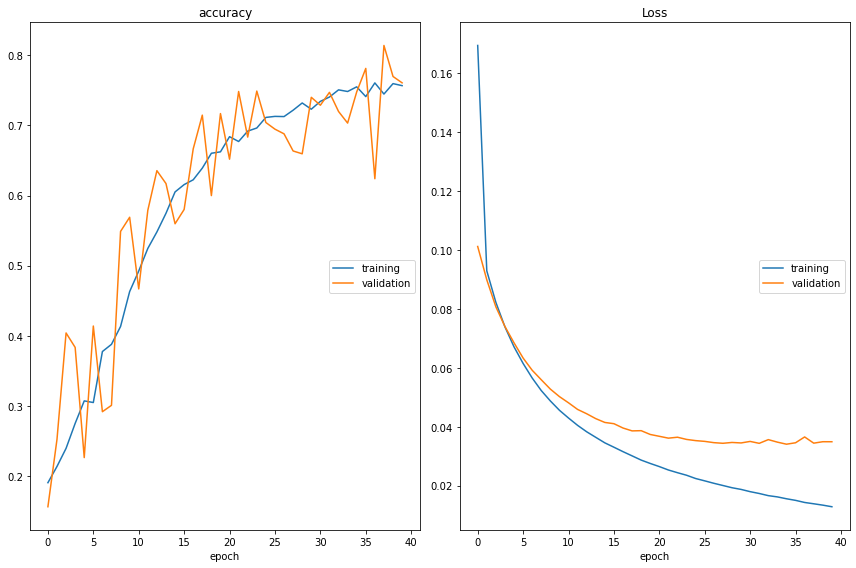

accuracy
	training         	 (min:    0.191, max:    0.761, cur:    0.757)
	validation       	 (min:    0.156, max:    0.814, cur:    0.761)
Loss
	training         	 (min:    0.013, max:    0.170, cur:    0.013)
	validation       	 (min:    0.034, max:    0.101, cur:    0.035)

Epoch 40: val_accuracy did not improve from 0.81389
465/465 [==============================] - 1s 2ms/step - loss: 0.0128 - accuracy: 0.7566 - val_loss: 0.0349 - val_accuracy: 0.7606


In [77]:
EPOCHS = 100
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    validation_data=(X_test, y_test),
    callbacks=[PlotLossesCallback(), checkpoint])

In [ ]:
targets_list[0].sum(axis=0)

In [ ]:
df[df['ОНМК'] == 1].shape

In [43]:
proba = df.copy()

In [44]:
proba_9 = proba[(proba['Артериальная гипертензия'] == 0)]
proba_9.iloc[:, 23:28].to_numpy().sum(axis=0)

array([ 0, 10, 16, 13, 34], dtype=int64)

In [45]:
proba_10 = proba[(proba['Артериальная гипертензия'] == 0) & (proba['Стенокардия, ИБС, инфаркт миокарда'] == 0)]
proba_10.iloc[:, 23:28].to_numpy().sum(axis=0)

array([ 0, 10,  0,  8, 33], dtype=int64)

In [46]:
proba_11 = proba[(proba['Артериальная гипертензия'] == 0)]
proba_11.iloc[:, 23:28].to_numpy().sum(axis=0)

array([ 0, 10, 16, 13, 34], dtype=int64)

In [47]:
proba_12 = proba[(proba['Артериальная гипертензия'] == 0) & (proba['Стенокардия, ИБС, инфаркт миокарда'] == 0) & (proba['Прочие заболевания сердца'] == 0)]
proba_12.iloc[:, 23:28].to_numpy().sum(axis=0)

array([ 0, 10,  0,  5,  0], dtype=int64)

In [48]:
proba_8 = proba[(proba['Артериальная гипертензия'] == 0) & (proba['Прочие заболевания сердца'] == 0)]
proba_8.iloc[:, 23:28].to_numpy().sum(axis=0)

array([ 0, 10, 15, 10,  0], dtype=int64)

In [ ]:
proba[proba['ОНМК'] == 1].iloc[:, 23:28].to_numpy().sum(axis=0)

In [ ]:
proba[proba['Стенокардия, ИБС, инфаркт миокарда'] == 1].iloc[:, 23:28].to_numpy().sum(axis=0)

In [ ]:
proba[proba['Сердечная недостаточность'] == 1].iloc[:, 23:28].to_numpy().sum(axis=0)

In [ ]:
proba[proba['Прочие заболевания сердца'] == 1].iloc[:, 23:28].to_numpy().sum(axis=0)

In [ ]:
proba_1 = proba[proba['Артериальная гипертензия'] == 1]
proba_2 = proba[proba['ОНМК'] == 1]
proba_3 = proba[proba['Стенокардия, ИБС, инфаркт миокарда'] == 1]
proba_4 = proba[proba['Сердечная недостаточность'] == 1]
proba_5 = proba[proba['Прочие заболевания сердца'] == 1]

In [64]:
for i in range(5):
    proba = pd.concat([proba, proba_8])

In [65]:
proba.iloc[:, 23:28].to_numpy().sum(axis=0)

array([440, 440, 417, 426, 415], dtype=int64)

In [66]:
proba = proba.sample(frac = 1)

In [67]:
proba.shape

(19815, 87)

In [68]:
XX = MinMaxScaler().fit_transform(proba.drop(columns = ['Артериальная гипертензия', 'ОНМК',\
    'Стенокардия, ИБС, инфаркт миокарда', 'Сердечная недостаточность', 'Прочие заболевания сердца']).values)

In [69]:
yy = MinMaxScaler().fit_transform(proba[['Артериальная гипертензия', 'ОНМК',\
    'Стенокардия, ИБС, инфаркт миокарда', 'Сердечная недостаточность', 'Прочие заболевания сердца']].values)

In [ ]:
type(XX)

In [ ]:
yy.shape

In [138]:
test_df = pd.read_csv('test_dataset_test.csv')
test_df.head()

,ID,Пол,Семья,Этнос,Национальность,Религия,Образование,Профессия,Вы работаете?,Выход на пенсию,Прекращение работы по болезни,Сахарный диабет,Гепатит,Онкология,Хроническое заболевание легких,Бронжиальная астма,Туберкулез легких,ВИЧ/СПИД,Регулярный прим лекарственных средств,Травмы за год,Переломы,Статус Курения,Возраст курения,Сигарет в день,Пассивное курение,Частота пасс кур,Алкоголь,Возраст алког,Время засыпания,Время пробуждения,Сон после обеда,"Спорт, клубы","Религия, клубы"
0,54-001-019-01,Ж,вдовец / вдова,европейская,Русские,Христианство,3 - средняя школа / закон.среднее / выше среднего,ремесленники и представители других отраслей п...,1,0,0,0,0,0,0,0,0,0,1,1,1,Никогда не курил(а),NaN,NaN,0,NaN,употребляю в настоящее время,23.0,21:30:00,05:00:00,0,1,1
1,54-002-133-01,Ж,в разводе,европейская,Русские,Христианство,5 - ВУЗ,дипломированные специалисты,0,1,0,0,0,0,0,0,0,0,1,0,0,Никогда не курил(а),NaN,NaN,0,NaN,употребляю в настоящее время,22.0,00:00:00,09:00:00,0,0,0
2,54-001-007-01,Ж,в браке в настоящее время,европейская,Русские,Христианство,5 - ВУЗ,дипломированные специалисты,0,1,0,0,0,0,0,0,0,0,1,0,0,Никогда не курил(а),NaN,NaN,0,NaN,употребляю в настоящее время,18.0,23:00:00,07:30:00,0,0,0
3,54-102-116-01,Ж,в браке в настоящее время,европейская,Русские,Христианство,4 - профессиональное училище,низкоквалифицированные работники,1,0,0,0,1,0,0,0,0,0,0,0,1,Никогда не курил(а),NaN,NaN,0,NaN,никогда не употреблял,NaN,22:00:00,06:00:00,0,0,0
4,54-502-005-02,М,в браке в настоящее время,европейская,Русские,Христианство,3 - средняя школа / закон.среднее / выше среднего,операторы и монтажники установок и машинного о...,0,1,0,0,0,0,0,0,0,0,1,1,1,Курит,14.0,20.0,0,NaN,употребляю в настоящее время,19.0,22:00:00,06:00:00,0,0,0


<AxesSubplot:>

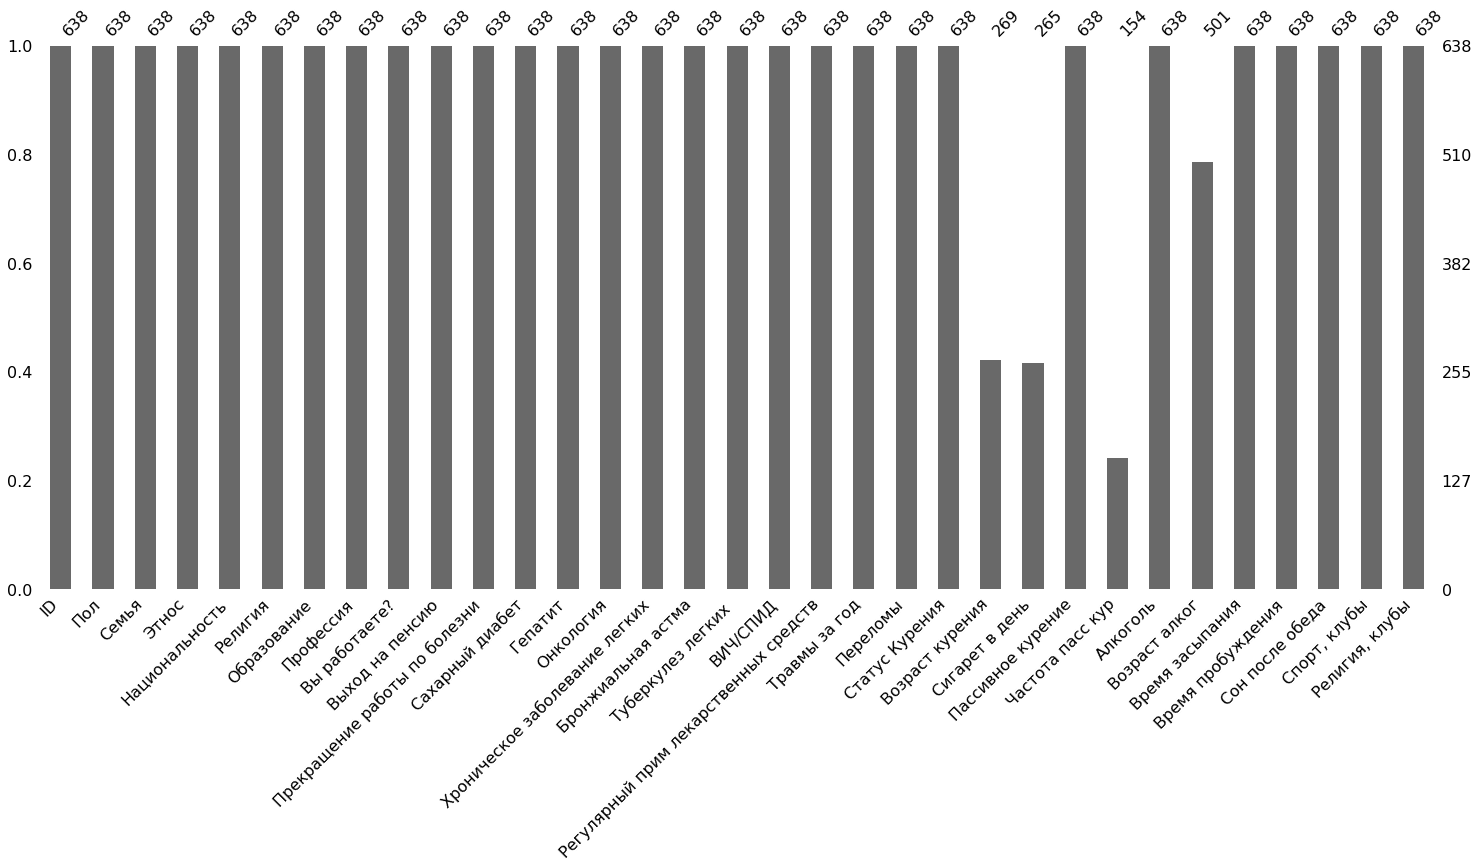

In [139]:
msno.bar(test_df)

In [140]:
test_df.loc[test_df['Статус Курения'] == 'Никогда не курил', 'Статус Курения'] = 'Никогда не курил(а)'

In [141]:
test_df.describe(include=[object])

,ID,Пол,Семья,Этнос,Национальность,Религия,Образование,Профессия,Статус Курения,Частота пасс кур,Алкоголь,Время засыпания,Время пробуждения
count,638,638,638,638,638,638,638,638,638,154,638,638,638
unique,638,2,6,3,11,6,4,11,3,5,3,22,31
top,54-001-019-01,Ж,в браке в настоящее время,европейская,Русские,Христианство,4 - профессиональное училище,дипломированные специалисты,Никогда не курил(а),1-2 раза в неделю,употребляю в настоящее время,23:00:00,06:00:00
freq,1,450,374,628,601,557,303,157,369,66,412,207,163


In [126]:
test_df = test_df.set_index('ID')

In [127]:
test_df.head()

,Пол,Семья,Этнос,Национальность,Религия,Образование,Профессия,Вы работаете?,Выход на пенсию,Прекращение работы по болезни,Сахарный диабет,Гепатит,Онкология,Хроническое заболевание легких,Бронжиальная астма,Туберкулез легких,ВИЧ/СПИД,Регулярный прим лекарственных средств,Травмы за год,Переломы,Статус Курения,Возраст курения,Сигарет в день,Пассивное курение,Частота пасс кур,Алкоголь,Возраст алког,Время засыпания,Время пробуждения,Сон после обеда,"Спорт, клубы","Религия, клубы"
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
54-001-019-01,Ж,вдовец / вдова,европейская,Русские,Христианство,3 - средняя школа / закон.среднее / выше среднего,ремесленники и представители других отраслей п...,1,0,0,0,0,0,0,0,0,0,1,1,1,Никогда не курил(а),NaN,NaN,0,NaN,употребляю в настоящее время,23.0,21:30:00,05:00:00,0,1,1
54-002-133-01,Ж,в разводе,европейская,Русские,Христианство,5 - ВУЗ,дипломированные специалисты,0,1,0,0,0,0,0,0,0,0,1,0,0,Никогда не курил(а),NaN,NaN,0,NaN,употребляю в настоящее время,22.0,00:00:00,09:00:00,0,0,0
54-001-007-01,Ж,в браке в настоящее время,европейская,Русские,Христианство,5 - ВУЗ,дипломированные специалисты,0,1,0,0,0,0,0,0,0,0,1,0,0,Никогда не курил(а),NaN,NaN,0,NaN,употребляю в настоящее время,18.0,23:00:00,07:30:00,0,0,0
54-102-116-01,Ж,в браке в настоящее время,европейская,Русские,Христианство,4 - профессиональное училище,низкоквалифицированные работники,1,0,0,0,1,0,0,0,0,0,0,0,1,Никогда не курил(а),NaN,NaN,0,NaN,никогда не употреблял,NaN,22:00:00,06:00:00,0,0,0
54-502-005-02,М,в браке в настоящее время,европейская,Русские,Христианство,3 - средняя школа / закон.среднее / выше среднего,операторы и монтажники установок и машинного о...,0,1,0,0,0,0,0,0,0,0,1,1,1,Курит,14.0,20.0,0,NaN,употребляю в настоящее время,19.0,22:00:00,06:00:00,0,0,0


In [128]:
test_df.dtypes

Пол                                       object
Семья                                     object
Этнос                                     object
Национальность                            object
Религия                                   object
Образование                               object
Профессия                                 object
Вы работаете?                              int64
Выход на пенсию                            int64
Прекращение работы по болезни              int64
Сахарный диабет                            int64
Гепатит                                    int64
Онкология                                  int64
Хроническое заболевание легких             int64
Бронжиальная астма                         int64
Туберкулез легких                          int64
ВИЧ/СПИД                                   int64
Регулярный прим лекарственных средств      int64
Травмы за год                              int64
Переломы                                   int64
Статус Курения      

In [129]:
test_df[['Время засыпания', 'Время пробуждения']] = test_df[['Время засыпания', 'Время пробуждения']].astype('datetime64')
test_df[['Время засыпания', 'Время пробуждения']].dtypes

Время засыпания      datetime64[ns]
Время пробуждения    datetime64[ns]
dtype: object

In [130]:
test_df['Время сна'] = test_df['Время пробуждения'] - test_df['Время засыпания']

In [131]:
def sleep_time(x):
    x = int(x.total_seconds()) // 3600
    if x < 0:
        x += 24
    return x
test_df['Время сна'] = test_df['Время сна'].apply(lambda x: sleep_time(x))

In [93]:
# model.save('my_model.h5')

In [132]:
test_df = test_df.fillna(0)
test_df[['Возраст курения', 'Сигарет в день', 'Возраст алког']] =\
test_df[['Возраст курения', 'Сигарет в день', 'Возраст алког']].astype('int64')

In [133]:
print(f'В столбце "Пол":  ', end = '')
cat_col = test_df['Пол'].astype('category')
codes = cat_col.cat.codes
cats = cat_col.cat.categories
test_df.loc[:, 'Пол'] = codes
print(f'{cats[0]} --> 0,  ', end = '')
print(f'{cats[1]} --> 1.')  

В столбце "Пол":  Ж --> 0,  М --> 1.


In [134]:
test_df = pd.get_dummies(test_df)

In [135]:
test_df[['Время засыпания', 'Время пробуждения']] = test_df.loc[:, ['Время засыпания', 'Время пробуждения']].applymap(lambda x: int(x.hour))
test_df.head()

,Пол,Вы работаете?,Выход на пенсию,Прекращение работы по болезни,Сахарный диабет,Гепатит,Онкология,Хроническое заболевание легких,Бронжиальная астма,Туберкулез легких,ВИЧ/СПИД,Регулярный прим лекарственных средств,Травмы за год,Переломы,Возраст курения,Сигарет в день,Пассивное курение,Возраст алког,Время засыпания,Время пробуждения,Сон после обеда,"Спорт, клубы","Религия, клубы",Время сна,Семья_в браке в настоящее время,Семья_в разводе,Семья_вдовец / вдова,Семья_гражданский брак / проживание с партнером,Семья_никогда не был(а) в браке,Семья_раздельное проживание (официально не разведены),"Этнос_другая азиатская (Корея, Малайзия, Таиланд, Вьетнам, Казахстан, Киргизия, Туркмения, Узбекистан, Таджикистан)",Этнос_европейская,"Этнос_прочее (любая иная этно-расовая группа, не представленная выше)",Национальность_Армяне,Национальность_Белорусы,Национальность_Другие национальности,Национальность_Казахи,Национальность_Лезгины,Национальность_Немцы,Национальность_Русские,Национальность_Татары,Национальность_Удмурты,Национальность_Украинцы,Национальность_Чуваши,Религия_Атеист / агностик,Религия_Другое,Религия_Индуизм,Религия_Ислам,Религия_Нет,Религия_Христианство,Образование_2 - начальная школа,Образование_3 - средняя школа / закон.среднее / выше среднего,Образование_4 - профессиональное училище,Образование_5 - ВУЗ,Профессия_ведение домашнего хозяйства,Профессия_вооруженные силы,Профессия_дипломированные специалисты,Профессия_квалифицированные работники сельского хозяйства и рыболовного,Профессия_низкоквалифицированные работники,Профессия_операторы и монтажники установок и машинного оборудования,"Профессия_представители законодат. органов власти, высокопостав. долж.лица и менеджеры","Профессия_работники, занятые в сфере обслуживания, торговые работники магазинов и рынков",Профессия_ремесленники и представители других отраслей промышленности,Профессия_служащие,Профессия_техники и младшие специалисты,Статус Курения_Бросил(а),Статус Курения_Курит,Статус Курения_Никогда не курил(а),Частота пасс кур_0,Частота пасс кур_1-2 раза в неделю,Частота пасс кур_2-3 раза в день,Частота пасс кур_3-6 раз в неделю,Частота пасс кур_4 и более раз в день,Частота пасс кур_не менее 1 раза в день,Алкоголь_никогда не употреблял,Алкоголь_ранее употреблял,Алкоголь_употребляю в настоящее время
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
54-001-019-01,0,1,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,23,21,5,0,1,1,7,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,1
54-002-133-01,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,22,0,9,0,0,0,9,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1
54-001-007-01,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,18,23,7,0,0,0,8,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1
54-102-116-01,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,22,6,0,0,0,8,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0
54-502-005-02,1,0,1,0,0,0,0,0,0,0,0,1,1,1,14,20,0,19,22,6,0,0,0,8,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1


In [136]:
test_X_test = MinMaxScaler().fit_transform(test_df.values)

In [137]:
test_df.columns

Index(['Пол', 'Вы работаете?', 'Выход на пенсию',
       'Прекращение работы по болезни', 'Сахарный диабет', 'Гепатит',
       'Онкология', 'Хроническое заболевание легких', 'Бронжиальная астма',
       'Туберкулез легких ', 'ВИЧ/СПИД',
       'Регулярный прим лекарственных средств', 'Травмы за год', 'Переломы',
       'Возраст курения', 'Сигарет в день', 'Пассивное курение',
       'Возраст алког', 'Время засыпания', 'Время пробуждения',
       'Сон после обеда', 'Спорт, клубы', 'Религия, клубы', 'Время сна',
       'Семья_в браке в настоящее время', 'Семья_в разводе',
       'Семья_вдовец / вдова',
       'Семья_гражданский брак / проживание с партнером',
       'Семья_никогда не был(а) в браке',
       'Семья_раздельное проживание (официально не разведены)',
       'Этнос_другая азиатская (Корея, Малайзия, Таиланд, Вьетнам, Казахстан, Киргизия, Туркмения, Узбекистан, Таджикистан)',
       'Этнос_европейская',
       'Этнос_прочее (любая иная этно-расовая группа, не представленная вы

In [107]:
test_df['Статус Курения'].value_counts()

KeyError: 'Статус Курения'

In [3]:
df = pd.read_csv('sample_solution.csv')
df.head()

,ID,Артериальная гипертензия,ОНМК,"Стенокардия, ИБС, инфаркт миокарда",Сердечная недостаточность,Прочие заболевания сердца
0,54-001-019-01,0,0,0,0,0
1,54-002-133-01,0,0,0,0,0
2,54-001-007-01,0,0,0,0,0
3,54-102-116-01,0,0,0,0,0
4,54-502-005-02,0,0,0,0,0


In [4]:
df.dtypes

ID                                    object
Артериальная гипертензия               int64
ОНМК                                   int64
Стенокардия, ИБС, инфаркт миокарда     int64
Сердечная недостаточность              int64
Прочие заболевания сердца              int64
dtype: object